# Healthcare Early-Warning AI using Synthetic EHR Data (Synthea)

This notebook builds an early-warning machine learning model using synthetic electronic health record (EHR) data generated by **Synthea**.

**Goal:** Predict the short-term risk that a patient will require a **hospital encounter** (e.g. inpatient / emergency visit) based on their past clinical history and demographics.

This type of model is similar in spirit to research done with real ICU/EHR datasets (e.g. MIMIC, eICU), but here we use synthetic data so that we can freely experiment without any privacy issues.


## Project Plan

We will follow these steps:

1. **Set up environment**  
   - Mount Google Drive  
   - Define data paths  
   - Import core Python libraries

2. **Load Synthea data (CSV)**  
   - `patients.csv`  
   - `encounters.csv`  
   - `conditions.csv`  
   - `observations.csv`

3. **Understand the data model**  
   - How tables relate to each other  
   - Basic exploratory analysis

4. **Define prediction problem**  
   - Early-warning label: *Will this patient have a hospital encounter in the next 30 days?*

5. **Build analysis dataset**  
   - Aggregate patient-level features from multiple tables  
   - Create the target label

6. **Train baseline models**  
   - Logistic Regression / Random Forest / Gradient Boosting  
   - Evaluate with ROC-AUC, Precision, Recall


In [ ]:
# 1.1 Mount Google Drive to access data files
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1.2 Set the path to the Synthea CSV folder and list available files
import os

DATA_DIR = "/content/drive/MyDrive/synthea"  # change if your folder name/path is different

# Show files in the directory to confirm the path is correct
os.listdir(DATA_DIR)

['encounters.csv',
 'providers.csv',
 'allergies.csv',
 'careplans.csv',
 'conditions.csv',
 'imaging_studies.csv',
 'immunizations.csv',
 'payers.csv',
 'supplies.csv',
 'medications.csv',
 'payer_transitions.csv',
 'devices.csv',
 'claims_transactions.csv',
 'observations.csv',
 'procedures.csv',
 'claims.csv',
 'organizations.csv',
 'patients.csv']

In [ ]:
# 1.3 Import core Python libraries for analysis and modelling

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Make plots a bit prettier and larger
plt.style.use("default")
sns.set()

## 2. Load Synthea CSV Tables

Synthea provides multiple linked tables that represent different aspects of a patient's medical history:

- **patients.csv** – one row per patient (demographics).
- **encounters.csv** – clinical visits/contacts with the healthcare system.
- **conditions.csv** – diagnoses assigned to patients.
- **observations.csv** – measurements such as vitals or lab-like values.

In this step we load these tables into Pandas DataFrames for exploration.


In [ ]:
# 2.1 Load core Synthea tables

patients = pd.read_csv(f"{DATA_DIR}/patients.csv")
encounters = pd.read_csv(f"{DATA_DIR}/encounters.csv")
conditions = pd.read_csv(f"{DATA_DIR}/conditions.csv")
observations = pd.read_csv(f"{DATA_DIR}/observations.csv")

In [ ]:
# 2.2 Inspect the first few rows of each table to understand the structure

print("Patients:")
display(patients.head())

print("\nEncounters:")
display(encounters.head())

print("\nConditions:")
display(conditions.head())

print("\nObservations:")
display(observations.head())

Patients:


,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,MIDDLE,LAST,...,CITY,STATE,COUNTY,FIPS,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,INCOME
0,45dff467-def6-2132-a03a-5950e203b5c8,1977-11-05,NaN,999-99-5823,S99991279,X28392886X,Mr.,Kris249,Ezequiel972,Moore224,...,Hudson,Massachusetts,Middlesex County,25017.0,1749,42.412388,-71.523562,104982.28,10945.37,45797
1,41e3b05f-43dc-a488-c593-d14d479b9091,1962-05-13,NaN,999-58-7605,S99923886,X25494937X,Mr.,Boyce638,Howard613,Hansen121,...,Leominster,Massachusetts,Worcester County,25027.0,1420,42.517587,-71.773606,127438.38,85176.74,82489
2,0bdb38c0-fe9f-f2dd-f7e0-0ba7eddb4738,1962-06-03,NaN,999-32-8956,S99960713,X16309304X,Mr.,Jody426,Dallas143,McGlynn426,...,Wakefield,Massachusetts,Middlesex County,25009.0,1940,42.549621,-70.998783,466903.21,89646.91,45298
3,10ecc353-34e9-2ab7-dea9-b7ff6b838b20,2020-08-08,NaN,999-94-6606,NaN,NaN,NaN,Azalee124,Reena181,Ankunding277,...,Hatfield,Massachusetts,Hampshire County,25015.0,1038,42.372674,-72.641256,9687.19,5.33,64825
4,092055e1-eb28-57d2-d914-ab03727a4ebc,2007-06-18,NaN,999-62-7403,S99996282,NaN,Ms.,Michaela318,Ela754,Von197,...,Swampscott,Massachusetts,Essex County,25009.0,1907,42.510106,-70.869277,60036.06,8297.63,134174



Encounters:


,Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION
0,45dff467-def6-2132-8f92-39a4105bfc61,1987-01-27T05:21:42Z,1987-01-27T05:36:42Z,45dff467-def6-2132-a03a-5950e203b5c8,352f2e3b-0708-3eb4-9f7e-e73a685bf379,1978b98a-2521-37db-bde4-3ecf576b55f3,e03e23c9-4df1-3eb6-a62d-f70f02301496,ambulatory,185345009,Encounter for symptom (procedure),85.55,92.93,0.0,36971009.0,Sinusitis (disorder)
1,45dff467-def6-2132-3703-014f32323de2,1995-12-30T07:21:42Z,1995-12-30T08:12:09Z,45dff467-def6-2132-a03a-5950e203b5c8,981338c4-287c-3621-bc45-8b0b9f1b8922,8f4c2d28-11d6-3fda-a362-0eed0b3d6342,e03e23c9-4df1-3eb6-a62d-f70f02301496,wellness,162673000,General examination of patient (procedure),136.80,922.00,0.0,NaN,NaN
2,45dff467-def6-2132-b4aa-505b537b65ae,2003-01-11T07:21:42Z,2003-01-11T08:19:35Z,45dff467-def6-2132-a03a-5950e203b5c8,981338c4-287c-3621-bc45-8b0b9f1b8922,8f4c2d28-11d6-3fda-a362-0eed0b3d6342,e03e23c9-4df1-3eb6-a62d-f70f02301496,wellness,162673000,General examination of patient (procedure),136.80,919.90,0.0,NaN,NaN
3,45dff467-def6-2132-4c1b-fd91dc11097b,2006-01-14T07:21:42Z,2006-01-14T08:17:26Z,45dff467-def6-2132-a03a-5950e203b5c8,981338c4-287c-3621-bc45-8b0b9f1b8922,8f4c2d28-11d6-3fda-a362-0eed0b3d6342,e03e23c9-4df1-3eb6-a62d-f70f02301496,wellness,162673000,General examination of patient (procedure),136.80,1577.04,0.0,NaN,NaN
4,45dff467-def6-2132-dd74-9b491ab2b598,2010-08-21T07:21:42Z,2010-08-21T08:04:13Z,45dff467-def6-2132-a03a-5950e203b5c8,352f2e3b-0708-3eb4-9f7e-e73a685bf379,1978b98a-2521-37db-bde4-3ecf576b55f3,8fa6c185-e44e-3e34-8bd8-39be8694f4ce,outpatient,185349003,Encounter for check up (procedure),85.55,950.03,0.0,NaN,NaN



Conditions:


,START,STOP,PATIENT,ENCOUNTER,SYSTEM,CODE,DESCRIPTION
0,1987-01-27,NaN,45dff467-def6-2132-a03a-5950e203b5c8,45dff467-def6-2132-8f92-39a4105bfc61,http://snomed.info/sct,40055000,Chronic sinusitis (disorder)
1,1995-12-30,NaN,45dff467-def6-2132-a03a-5950e203b5c8,45dff467-def6-2132-3703-014f32323de2,http://snomed.info/sct,224299000,Received higher education (finding)
2,2003-01-11,NaN,45dff467-def6-2132-a03a-5950e203b5c8,45dff467-def6-2132-b4aa-505b537b65ae,http://snomed.info/sct,422650009,Social isolation (finding)
3,2003-01-11,NaN,45dff467-def6-2132-a03a-5950e203b5c8,45dff467-def6-2132-b4aa-505b537b65ae,http://snomed.info/sct,266948004,Has a criminal record (finding)
4,2006-01-14,NaN,45dff467-def6-2132-a03a-5950e203b5c8,45dff467-def6-2132-4c1b-fd91dc11097b,http://snomed.info/sct,714628002,Prediabetes (finding)



Observations:


,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,DESCRIPTION,VALUE,UNITS,TYPE
0,2017-11-11T07:21:42Z,45dff467-def6-2132-a03a-5950e203b5c8,45dff467-def6-2132-9e5c-0a836d754d92,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,5.8,%,numeric
1,2017-11-11T07:21:42Z,45dff467-def6-2132-a03a-5950e203b5c8,45dff467-def6-2132-9e5c-0a836d754d92,vital-signs,8302-2,Body Height,186.4,cm,numeric
2,2017-11-11T07:21:42Z,45dff467-def6-2132-a03a-5950e203b5c8,45dff467-def6-2132-9e5c-0a836d754d92,vital-signs,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,3.0,{score},numeric
3,2017-11-11T07:21:42Z,45dff467-def6-2132-a03a-5950e203b5c8,45dff467-def6-2132-9e5c-0a836d754d92,vital-signs,29463-7,Body Weight,98.0,kg,numeric
4,2017-11-11T07:21:42Z,45dff467-def6-2132-a03a-5950e203b5c8,45dff467-def6-2132-9e5c-0a836d754d92,vital-signs,39156-5,Body mass index (BMI) [Ratio],28.2,kg/m2,numeric


## 3. Data Model – How the Tables Link Together

Each table uses a patient identifier so that we can connect information across tables:

- `patients.Id` is the unique ID for each patient.
- `encounters.PATIENT` refers to `patients.Id`.
- `conditions.PATIENT` refers to `patients.Id`.
- `observations.PATIENT` refers to `patients.Id`.

So the relationships are:

- **Patients 1 ↔ N Encounters**
- **Patients 1 ↔ N Conditions**
- **Patients 1 ↔ N Observations**

This is similar to real electronic health records (EHR) systems.  
We will eventually build a **patient-level dataset** that aggregates information from all these tables.


## 4. Data Quality & Missingness (EHR Perspective)

Unlike typical Kaggle/tabular datasets, missing values in health records are usually **informative** and should not be discarded without reflection.

For example:
- If a patient has **no observations (vitals/labs)**, it may indicate they were not admitted or not acutely ill.
- If a patient has **no chronic conditions**, they may be healthy.
- If a patient has **no inpatient encounters**, they may not have required acute care.

Before building features, we will:
1. Inspect null values
2. Examine missingness patterns across tables
3. Decide which missingness should become a feature rather than being dropped


In [ ]:
# 4.1 Check missingness across main tables

def missing_summary(df):
    return pd.DataFrame({
        'missing_count': df.isna().sum(),
        'missing_pct': df.isna().mean() * 100
    }).sort_values('missing_pct', ascending=False)

print("Patients missingness:")
display(missing_summary(patients))

print("\nEncounters missingness:")
display(missing_summary(encounters))

print("\nConditions missingness:")
display(missing_summary(conditions))

print("\nObservations missingness:")
display(missing_summary(observations))

Patients missingness:


,missing_count,missing_pct
SUFFIX,115,100.000000
DEATHDATE,100,86.956522
MAIDEN,88,76.521739
MARITAL,39,33.913043
PASSPORT,24,20.869565
PREFIX,22,19.130435
MIDDLE,20,17.391304
DRIVERS,19,16.521739
FIPS,18,15.652174
BIRTHDATE,0,0.000000



Encounters missingness:


,missing_count,missing_pct
REASONCODE,2649,37.336152
REASONDESCRIPTION,2649,37.336152
Id,0,0.000000
PATIENT,0,0.000000
ORGANIZATION,0,0.000000
START,0,0.000000
STOP,0,0.000000
PAYER,0,0.000000
PROVIDER,0,0.000000
ENCOUNTERCLASS,0,0.000000



Conditions missingness:


,missing_count,missing_pct
STOP,1087,24.069973
START,0,0.000000
PATIENT,0,0.000000
ENCOUNTER,0,0.000000
SYSTEM,0,0.000000
CODE,0,0.000000
DESCRIPTION,0,0.000000



Observations missingness:


,missing_count,missing_pct
UNITS,26729,27.926196
CATEGORY,3225,3.369448
ENCOUNTER,3225,3.369448
DATE,0,0.000000
PATIENT,0,0.000000
CODE,0,0.000000
DESCRIPTION,0,0.000000
VALUE,0,0.000000
TYPE,0,0.000000


### Why We Do Not Simply Clean or Drop Missing Values

In typical machine learning datasets (e.g., Kaggle competitions), missing values are often treated as noise and removed or imputed. However, electronic health record (EHR) data has fundamentally different missingness characteristics:

- **Missingness is often informative**  
  The absence of certain measurements (e.g., vitals, labs) can indicate lower disease severity or lack of acute care.

- **Clinical concepts are time-dependent**  
  A patient may not have a `STOP` time for chronic conditions because the condition is ongoing.

- **Not all patients undergo the same assessments**  
  Lack of observations or encounters can be a clinically meaningful feature.

- **Data is heterogeneous and event-based**  
  Patients interact with the healthcare system based on need, not uniform schedules.

For these reasons, we do **not** drop rows with missing values at this stage. Instead, missingness will later be transformed into **features** (e.g., number of observations, presence/absence of inpatient encounters), which can provide predictive signal for early-warning tasks.

In the clinical machine learning literature, missing data is considered part of the underlying data-generating process rather than a preprocessing artifact. Prior work has shown that incorporating missingness as a feature can improve predictive performance in ICU and hospital readmission models (e.g., MIMIC, eICU, Deep EHR studies).



## 5. Define Early-Warning Prediction Target (30-Day Horizon)

To frame this dataset as a supervised learning problem, we define a binary prediction target at the patient level.

**Prediction Question:**  
> Will the patient experience a hospital-type encounter (e.g. inpatient or emergency encounter) within the next 30 days?

This type of task is commonly studied in clinical machine learning for proactive risk detection, triage, and resource planning.

To compute this target, we will:

1. Identify "hospital encounters" from the `encounters.csv` table.
2. Sort encounters chronologically for each patient.
3. For each encounter, check whether another hospital encounter occurs within the next 30 days.
4. Assign a binary target (`1` = event occurs, `0` = no event).

In [ ]:
# 5.1 Convert relevant date columns to datetime format

encounters['START'] = pd.to_datetime(encounters['START'])
encounters['STOP'] = pd.to_datetime(encounters['STOP'], errors='coerce')  # chronic events can have no STOP
conditions['START'] = pd.to_datetime(conditions['START'])
conditions['STOP'] = pd.to_datetime(conditions['STOP'], errors='coerce')
observations['DATE'] = pd.to_datetime(observations['DATE'])
patients['BIRTHDATE'] = pd.to_datetime(patients['BIRTHDATE'])
patients['DEATHDATE'] = pd.to_datetime(patients['DEATHDATE'], errors='coerce')

In [ ]:
# 5.2 Identify hospital-type encounters (positive signal candidates)

hospital_classes = ['inpatient', 'emergency', 'urgentcare']

encounters['hospital_flag'] = encounters['ENCOUNTERCLASS'].isin(hospital_classes).astype(int)

In [ ]:
# 5.3 Sort encounters by time within each patient
encounters = encounters.sort_values(by=['PATIENT', 'START'])

In [ ]:
# 5.4 Generate 30-day early-warning target

from datetime import timedelta

def compute_target(df, horizon=30):
    df = df.copy()
    df['target_30d'] = 0
    for idx in range(len(df)):
        if df.iloc[idx]['hospital_flag'] == 1:
            current_start = df.iloc[idx]['START']
            lookahead = current_start + timedelta(days=horizon)

            future = df[
                (df['START'] > current_start) &
                (df['START'] <= lookahead) &
                (df['hospital_flag'] == 1)
            ]

            if len(future) > 0:
                df.at[df.index[idx], 'target_30d'] = 1
    return df

encounters = encounters.groupby('PATIENT').apply(compute_target).reset_index(drop=True)

/tmp/ipython-input-3827952092.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  encounters = encounters.groupby('PATIENT').apply(compute_target).reset_index(drop=True)


In [ ]:
# 5.5 Check class distribution
encounters['target_30d'].value_counts()

,count
target_30d,
0,6772
1,323


## 6. Encounter-Level Prediction Framing

We frame this problem at the **encounter level**, meaning each clinical encounter serves as a reference point from which we predict whether the patient will require another hospital encounter within a short future horizon (30 days in our case).

This approach aligns with early-warning and deterioration prediction models frequently used in clinical machine learning research, particularly in ICU and hospital readmission studies.

Advantages of encounter-level framing:

- Treats patient history as a temporal sequence of events.
- Allows for multiple predictions per patient.
- Respects clinical workflows such as triage and discharge.
- Enables the use of temporal models (e.g., sequence models, LSTMs) if desired later.


### 6.1 Target Definition Finalization

From the previous step, we computed a binary target `target_30d` indicating whether a subsequent hospital encounter occurred within 30 days after a given encounter.

Since not all encounters are hospital encounters, we retain only encounters that could realistically precede a hospital event, and drop those where the patient has no future encounters recorded.


In [ ]:
# 6.2 Filter encounters to meaningful rows

# Remove encounters without a START timestamp (should be none, but safe)
encounters = encounters[~encounters['START'].isna()]

# Optionally drop patients with only a single encounter (no temporal info)
encounters = encounters.groupby('PATIENT').filter(lambda x: len(x) > 1).reset_index(drop=True)

Patients with only 1 encounter can’t form a future event, so they don’t contribute to supervised training.

In [ ]:
# 6.3 Examine class distribution
encounters['target_30d'].value_counts(normalize=True).to_frame('proportion') ## This tells us how often the next 30-day hospital event occurs.

,proportion
target_30d,
0,0.954469
1,0.045531


## 7. Feature Engineering (Encounter-Level)

To train a supervised model, we need to transform raw EHR tables into structured features that summarize patient status at each encounter.

For encounter-level modeling, we extract:

1. **Demographics (from patients.csv)**
    - age at encounter time
    - sex
    - race/ethnicity

2. **Encounter History**
    - total number of past encounters
    - number of emergency encounters in last 30/60/90 days
    - number of inpatient encounters in last 30/60/90 days

3. **Condition Burden (from conditions.csv)**
    - number of chronic conditions
    - number of active conditions at encounter time
    - comorbidity-like indicators

4. **Observation History (from observations.csv)**
    - count of lab/vital measurements
    - whether labs were ordered (yes/no)
    - missingness as signal

These features are commonly used in real EHR research and allow for flexible modeling approaches from logistic regression to sequence deep learning.


In [ ]:
# 7.1 Merge patient demographics into encounter table

# Clean patient ID column names for merge
patients.rename(columns={'Id':'PATIENT'}, inplace=True)

enc = encounters.merge(
    patients[['PATIENT','BIRTHDATE','DEATHDATE','GENDER','RACE','ETHNICITY']],
    on='PATIENT',
    how='left'
)


In [ ]:
# Ensure both datetime fields are tz-naive before subtraction
enc['START'] = enc['START'].dt.tz_localize(None)
enc['BIRTHDATE'] = enc['BIRTHDATE'].dt.tz_localize(None)

# Compute age at encounter time
enc['age'] = (enc['START'] - enc['BIRTHDATE']).dt.days / 365.25

### Handling Timezone-Aware Timestamps

Synthea encounter timestamps may include timezone information, whereas patient birthdates typically do not. Python does not allow subtraction between timezone-aware and timezone-naive datetimes. To enable valid time arithmetic, we strip timezone information using `.dt.tz_localize(None)` which preserves date values while harmonizing formats.


In [ ]:
enc[['PATIENT','START','ENCOUNTERCLASS','age','target_30d']].head()

,PATIENT,START,ENCOUNTERCLASS,age,target_30d
0,0050142f-2f30-0459-4614-3b9cbb082854,2010-04-30 11:30:41,ambulatory,1.015743,0
1,0050142f-2f30-0459-4614-3b9cbb082854,2015-04-10 11:30:41,wellness,5.960301,0
2,0050142f-2f30-0459-4614-3b9cbb082854,2016-04-15 11:30:41,wellness,6.976044,0
3,0050142f-2f30-0459-4614-3b9cbb082854,2017-04-21 11:30:41,wellness,7.991786,0
4,0050142f-2f30-0459-4614-3b9cbb082854,2018-04-27 11:30:41,wellness,9.007529,0


### 7.2 Condition-Based Features

Chronic and active conditions are strong predictors of healthcare utilization and acute deterioration risk.

From `conditions.csv` we extract:

- **Number of active conditions at encounter**
- **Total number of historical conditions**
- **Presence of chronic diseases**

This serves as a proxy for disease burden and comorbidity, which are commonly used in clinical machine learning studies.


In [ ]:
# Ensure conditions have proper datetime format
conditions['START'] = pd.to_datetime(conditions['START'])
conditions['STOP'] = pd.to_datetime(conditions['STOP'], errors='coerce')

A condition is active at an encounter if:

condition.START <= encounter.START <= condition.STOP (or STOP is missing)


Missing STOP means condition is chronic/ongoing → common in clinical data.

In [ ]:
# Function to count active conditions at encounter time
def count_active_conditions(enc_row):
    pid = enc_row['PATIENT']
    t = enc_row['START']

    conds = conditions[conditions['PATIENT'] == pid]

    active = conds[
        (conds['START'] <= t) &
        ((conds['STOP'].isna()) | (conds['STOP'] >= t))
    ]

    return len(active)

enc['active_conditions'] = enc.apply(count_active_conditions, axis=1)

In [ ]:
enc[['PATIENT','START','active_conditions','target_30d']].head()

,PATIENT,START,active_conditions,target_30d
0,0050142f-2f30-0459-4614-3b9cbb082854,2010-04-30 11:30:41,1,0
1,0050142f-2f30-0459-4614-3b9cbb082854,2015-04-10 11:30:41,2,0
2,0050142f-2f30-0459-4614-3b9cbb082854,2016-04-15 11:30:41,1,0
3,0050142f-2f30-0459-4614-3b9cbb082854,2017-04-21 11:30:41,2,0
4,0050142f-2f30-0459-4614-3b9cbb082854,2018-04-27 11:30:41,1,0


We treat `active_conditions` as a proxy for chronic disease burden. Higher values should correlate with higher future utilization risk.


### 7.3 Encounter History Features (Temporal)

Healthcare utilization patterns are predictive of future encounters.

We compute:

- Number of past encounters
- Number of emergency encounters (past 30/60/90 days)
- Number of inpatient encounters (past 30/60/90 days)
- Time since last encounter

These features capture temporal care patterns relevant in deterioration prediction.


In [ ]:
from datetime import timedelta

windows = [30, 60, 90]

for w in windows:
    col = f'past_encounters_{w}d'
    vals = []

    for i, row in enc.iterrows():
        pid = row['PATIENT']
        t = row['START']
        t_low = t - timedelta(days=w)

        subset = enc[(enc['PATIENT'] == pid) & (enc['START'] < t) & (enc['START'] >= t_low)]
        vals.append(len(subset))

    enc[col] = vals



In [ ]:
enc[['PATIENT','START','past_encounters_30d','past_encounters_60d','past_encounters_90d']].head()

,PATIENT,START,past_encounters_30d,past_encounters_60d,past_encounters_90d
0,0050142f-2f30-0459-4614-3b9cbb082854,2010-04-30 11:30:41,0,0,0
1,0050142f-2f30-0459-4614-3b9cbb082854,2015-04-10 11:30:41,0,0,0
2,0050142f-2f30-0459-4614-3b9cbb082854,2016-04-15 11:30:41,0,0,0
3,0050142f-2f30-0459-4614-3b9cbb082854,2017-04-21 11:30:41,0,0,0
4,0050142f-2f30-0459-4614-3b9cbb082854,2018-04-27 11:30:41,0,0,0


## 7.4 Observation-Based Features (Labs/Vitals Activity)

Clinical measurements such as labs and vital signs often serve as strong indicators of patient health status.
In addition, the frequency of measurements carries information: high monitoring density can indicate clinical concern or deterioration.

From `observations.csv` we compute:

- number of observations before each encounter
- number of observations in recent temporal windows (30, 60, 90 days)
- whether observations exist at all (missingness → signal)

These features are suitable for classical ML baselines.


In [ ]:
# Ensure datetime types (already done previously but safe to repeat)
observations['DATE'] = pd.to_datetime(observations['DATE'], errors='coerce')

# Harmonize timezone (very important for datetime comparisons)
observations['DATE'] = observations['DATE'].dt.tz_localize(None)
enc['START'] = enc['START'].dt.tz_localize(None)

In [ ]:
from datetime import timedelta

total_obs = []
for i, row in enc.iterrows():
    pid = row['PATIENT']
    t = row['START']

    subset = observations[
        (observations['PATIENT'] == pid) &
        (observations['DATE'] < t)
    ]

    total_obs.append(len(subset))

enc['obs_total_before'] = total_obs

In [ ]:
enc[['PATIENT','START','obs_total_before','target_30d']].head()

,PATIENT,START,obs_total_before,target_30d
0,0050142f-2f30-0459-4614-3b9cbb082854,2010-04-30 11:30:41,0,0
1,0050142f-2f30-0459-4614-3b9cbb082854,2015-04-10 11:30:41,0,0
2,0050142f-2f30-0459-4614-3b9cbb082854,2016-04-15 11:30:41,3,0
3,0050142f-2f30-0459-4614-3b9cbb082854,2017-04-21 11:30:41,16,0
4,0050142f-2f30-0459-4614-3b9cbb082854,2018-04-27 11:30:41,32,0


In [ ]:
windows = [30, 60, 90]

for w in windows:
    col = f'obs_{w}d'
    vals = []

    for i, row in enc.iterrows():
        pid = row['PATIENT']
        t = row['START']
        t_low = t - timedelta(days=w)

        subset = observations[
            (observations['PATIENT'] == pid) &
            (observations['DATE'] < t) &
            (observations['DATE'] >= t_low)
        ]

        vals.append(len(subset))

    enc[col] = vals

In [ ]:
# Binary signal: absence of observations may indicate low severity or under-monitoring
enc['obs_missing_flag'] = (enc['obs_total_before'] == 0).astype(int)

In [ ]:
enc[['PATIENT','START','obs_total_before','obs_30d','obs_60d','obs_90d','obs_missing_flag','target_30d']].head()

,PATIENT,START,obs_total_before,obs_30d,obs_60d,obs_90d,obs_missing_flag,target_30d
0,0050142f-2f30-0459-4614-3b9cbb082854,2010-04-30 11:30:41,0,0,0,0,1,0
1,0050142f-2f30-0459-4614-3b9cbb082854,2015-04-10 11:30:41,0,0,0,0,1,0
2,0050142f-2f30-0459-4614-3b9cbb082854,2016-04-15 11:30:41,3,0,0,0,0,0
3,0050142f-2f30-0459-4614-3b9cbb082854,2017-04-21 11:30:41,16,0,0,0,0,0
4,0050142f-2f30-0459-4614-3b9cbb082854,2018-04-27 11:30:41,32,3,3,3,0,0


## 8. Feature Summary

We engineered a set of encounter-level features derived from multiple clinical tables. These features represent patient demographics, chronic disease burden, healthcare utilization, and clinical monitoring activity.

| Feature | Source Table | Type | Description |
|--------|--------------|------|-------------|
| age | patients | continuous | Age at encounter time (years) |
| sex | patients | categorical | Biological sex (M/F) |
| race | patients | categorical | Race category |
| ethnicity | patients | categorical | Ethnicity category |
| active_conditions | conditions | count | Number of conditions active at encounter time |
| past_encounters_30d | encounters | count | Number of encounters in last 30 days |
| past_encounters_60d | encounters | count | Number of encounters in last 60 days |
| past_encounters_90d | encounters | count | Number of encounters in last 90 days |
| obs_total_before | observations | count | Total number of observations before encounter |
| obs_30d | observations | count | Observations within last 30 days |
| obs_60d | observations | count | Observations within last 60 days |
| obs_90d | observations | count | Observations within last 90 days |
| obs_missing_flag | observations | binary | 1 if no observations exist before encounter |
| year | encounters | categorical | Encounter year |
| month | encounters | categorical | Encounter month |
| weekday | encounters | categorical | Encounter day of week |
| target_30d | encounters | binary | Future hospital encounter within 30 days (label) |

This feature set is suitable for classical machine learning models (e.g., logistic regression, random forest, gradient boosting), while also allowing extension to deep temporal models.


## 9. Exploratory Data Analysis (EDA)

Before modeling, we examine the distribution of key features and their relationship with the target.
EDA helps validate that the engineered features carry signal and reveals imbalances, nonlinear effects, and sparsity patterns.


In [ ]:
enc['target_30d'].value_counts(normalize=True).to_frame('proportion')

,proportion
target_30d,
0,0.954469
1,0.045531


In [ ]:
enc.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Id,7094,7094,fea51c36-faca-d976-96f3-064c290ab9e9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
START,7094,NaN,NaN,NaN,2017-01-24 15:08:42.823512832,1937-03-03 01:45:04,2016-12-27 16:15:02,2020-02-26 15:21:54.500000,2023-01-29 07:04:28,2025-12-01 12:17:21,NaN
STOP,7094,NaN,NaN,NaN,2017-01-24 19:48:02.659571456+00:00,1937-03-03 02:33:31+00:00,2016-12-27 16:41:17+00:00,2020-02-26 17:01:02.500000+00:00,2023-01-29 07:53:13+00:00,2025-12-01 12:57:24+00:00,NaN
PATIENT,7094,114,fb62c08e-8900-5fb2-8a98-af95f64125ff,629,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORGANIZATION,7094,249,979d5316-97f4-335d-af9d-d0afba85dc6a,749,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PROVIDER,7094,249,49350ad1-3b85-37b8-a01d-1d3a07145e9c,749,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAYER,7094,10,a735bf55-83e9-331a-899d-a82a60b9f60c,2294,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENCOUNTERCLASS,7094,9,ambulatory,3876,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CODE,7094.0,NaN,NaN,NaN,261297450.652241,1505002.0,185345009.0,185348002.0,371883000.0,702927004.0,167109135.302616
DESCRIPTION,7094,45,Encounter for problem (procedure),1479,NaN,NaN,NaN,NaN,NaN,NaN,NaN


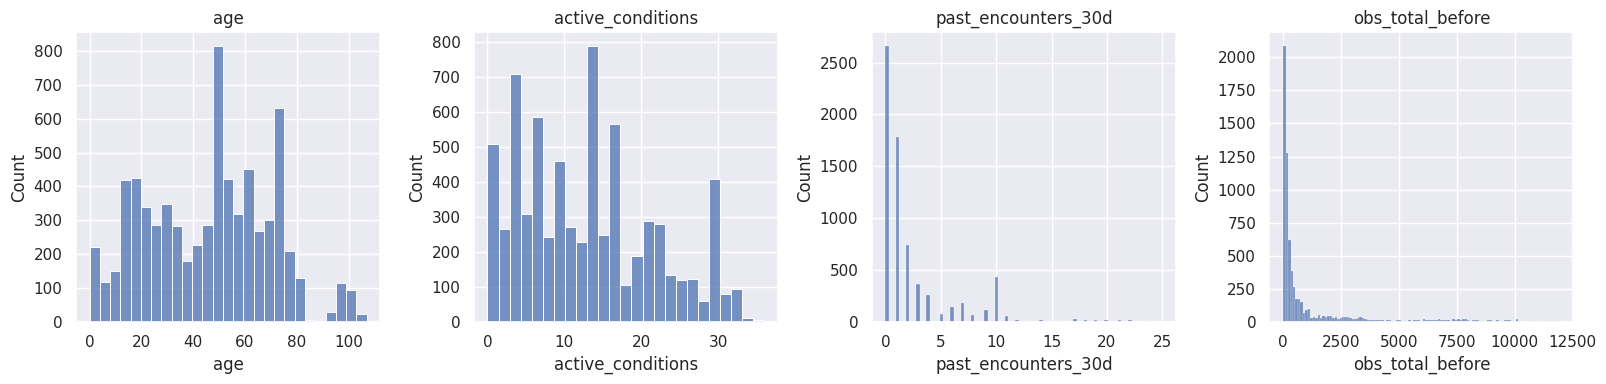

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = ['age','active_conditions','past_encounters_30d','obs_total_before']
fig, axes = plt.subplots(1, len(num_cols), figsize=(16,4))

for i, col in enumerate(num_cols):
    sns.histplot(enc[col], ax=axes[i], kde=False)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


The distribution plots show realistic healthcare patterns. Age is broadly distributed and peaks in older adults, active conditions are skewed with many low-burden patients and a smaller multi-morbid group, recent encounters show sparse but meaningful spikes, and total observations are heavily right-skewed with occasional high-monitoring episodes. These patterns reflect natural clinical variability and indicate that the data contains informative structure rather than noise.

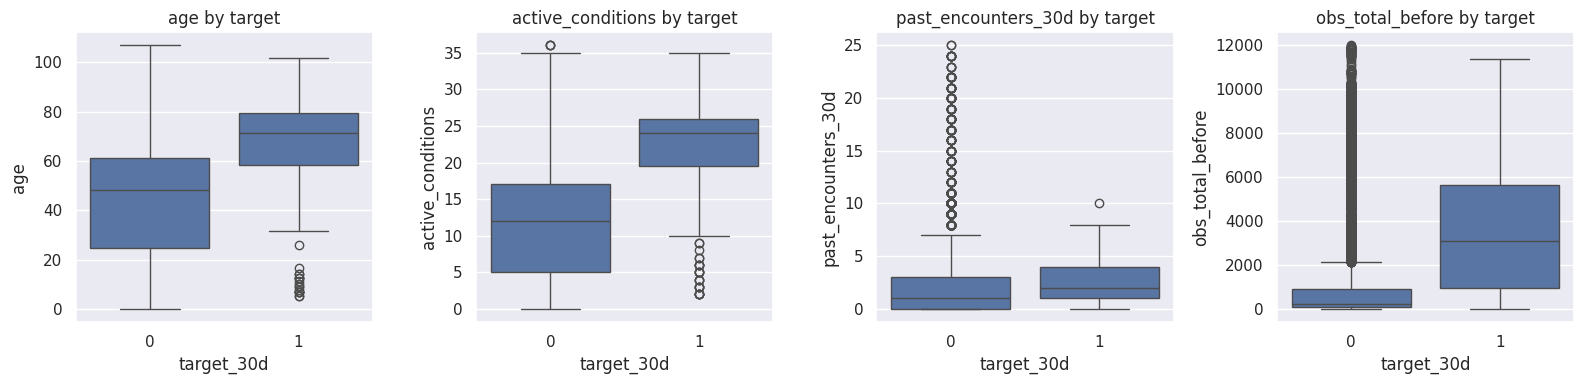

In [ ]:
fig, axes = plt.subplots(1, len(num_cols), figsize=(16,4))

for i, col in enumerate(num_cols):
    sns.boxplot(x='target_30d', y=col, data=enc, ax=axes[i])
    axes[i].set_title(f"{col} by target")

plt.tight_layout()
plt.show()

The box plots show clear differences between patients who deteriorate within 30 days and those who do not. The positive outcome group tends to be older, has more chronic conditions, higher recent utilization, and more clinical observations. These differences are clinically logical, as deterioration risk increases with age, multi-morbidity, and frequent healthcare contact. This confirms that the target label is not random and carries meaningful signal.

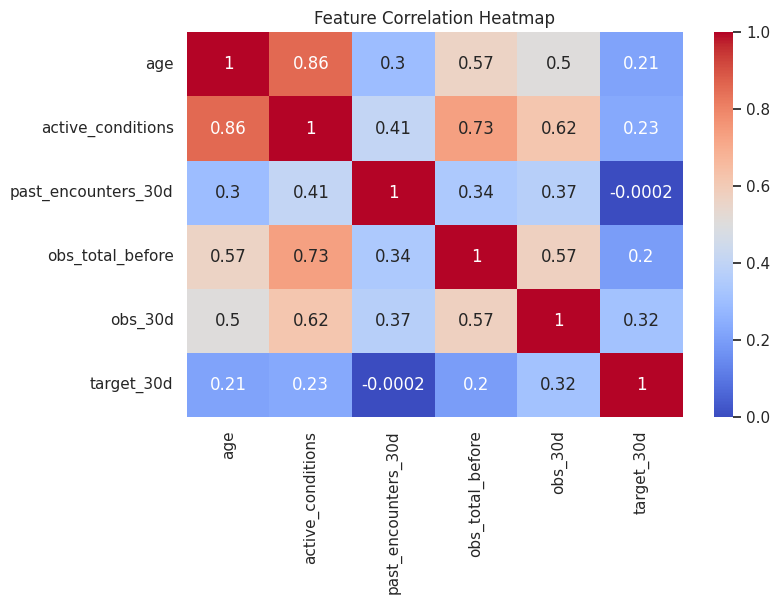

In [ ]:
corr_cols = ['age','active_conditions','past_encounters_30d','obs_total_before','obs_30d','target_30d']
plt.figure(figsize=(8,5))
sns.heatmap(enc[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

The correlation heatmap reveals moderate relationships among age, chronic conditions, and observation activity, reflecting underlying clinical dynamics. Direct correlations with the target are modest, suggesting the task is multifactorial and requires combining features rather than relying on a single predictor. This pattern is typical in healthcare prediction problems and indicates suitability for multivariate machine learning models.

In [ ]:
#from sklearn.model_selection import train_test_split

# Step 1: get unique patients
#unique_patients = enc['PATIENT'].unique()

# Step 2: split patients into train and test
#train_pats, test_pats = train_test_split(unique_patients, test_size=0.2, random_state=42)

# Step 3: map encounters to split based on patient id
##train_df = enc[enc['PATIENT'].isin(train_pats)].reset_index(drop=True)
#test_df = enc[enc['PATIENT'].isin(test_pats)].reset_index(drop=True)

# Confirm no overlap
#assert len(set(train_df['PATIENT']).intersection(set(test_df['PATIENT']))) == 0

#len(train_df), len(test_df)


In [ ]:
# Make sure demographic and temporal features exist in `enc`

enc['sex'] = enc['GENDER']
enc['race'] = enc['RACE']
enc['ethnicity'] = enc['ETHNICITY']

enc['year'] = enc['START'].dt.year
enc['month'] = enc['START'].dt.month
enc['weekday'] = enc['START'].dt.weekday

In [ ]:
from sklearn.model_selection import train_test_split

unique_patients = enc['PATIENT'].unique()
train_pats, test_pats = train_test_split(unique_patients, test_size=0.2, random_state=42)

train_df = enc[enc['PATIENT'].isin(train_pats)].reset_index(drop=True)
test_df  = enc[enc['PATIENT'].isin(test_pats)].reset_index(drop=True)

assert len(set(train_df['PATIENT']).intersection(set(test_df['PATIENT']))) == 0


In [ ]:
num_features = [
    'age',
    'active_conditions',
    'past_encounters_30d',
    'past_encounters_60d',
    'past_encounters_90d',
    'obs_total_before',
    'obs_30d',
    'obs_60d',
    'obs_90d'
]

cat_features = ['sex','race','ethnicity','year','month','weekday']
target = 'target_30d'

In [ ]:
# One-hot encode categorical features
train_X = pd.get_dummies(train_df[num_features + cat_features], drop_first=True)
test_X  = pd.get_dummies(test_df[num_features + cat_features], drop_first=True)

train_y = train_df[target]
test_y  = test_df[target]

# Align columns between train and test
train_X, test_X = train_X.align(test_X, join='left', axis=1)
test_X = test_X.fillna(0)

train_X.shape, test_X.shape

((5783, 19), (1311, 19))

## 10. Baseline Models & Evaluation

We now train baseline classical machine learning models on the engineered encounter-level feature set.

Models:
- Logistic Regression (interpretable linear baseline)
- Random Forest (nonlinear tree ensemble)
- (Optional) XGBoost (gradient-boosted trees, strong tabular baseline)

Evaluation focuses on metrics relevant for healthcare prediction:
- ROC-AUC (discrimination)
- PR-AUC (precision–recall trade-off, important for imbalanced data)
- Precision, Recall
- Confusion matrix

The positive class is `target_30d = 1` (future hospital encounter within 30 days).


## **10.1 Import Models & Metrics**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

## 10.2 Helper Function to Evaluate Models

In [ ]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """
    Fit model, compute key metrics, and plot confusion matrix.
    """
    model.fit(X_train, y_train)

    # Probabilities for metrics
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba  = model.predict_proba(X_test)[:, 1]

    # Predictions (0/1)
    y_test_pred = model.predict(X_test)

    # Metrics
    roc_auc = roc_auc_score(y_test, y_test_proba)
    pr_auc  = average_precision_score(y_test, y_test_proba)
    prec    = precision_score(y_test, y_test_pred, zero_division=0)
    rec     = recall_score(y_test, y_test_pred, zero_division=0)

    print(f"=== {name} ===")
    print(f"ROC-AUC: {roc_auc:.3f}")
    print(f"PR-AUC:  {pr_auc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return {
        'name': name,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'precision': prec,
        'recall': rec
    }

## 10.3 Logistic Regression (with Scaling & Class Weights)

=== Logistic Regression ===
ROC-AUC: 0.811
PR-AUC:  0.259
Precision: 0.147
Recall:    0.773


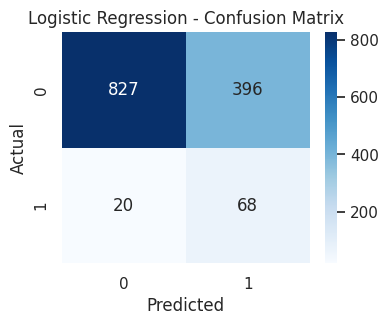

In [ ]:
# Logistic Regression pipeline: scaling + classifier
log_reg = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        max_iter=500,
        class_weight='balanced',
        n_jobs=-1
    ))
])

log_results = evaluate_model(
    "Logistic Regression",
    log_reg,
    train_X,
    train_y,
    test_X,
    test_y
)

## 10.4 Random Forest (Nonlinear Baseline)

=== Random Forest ===
ROC-AUC: 0.781
PR-AUC:  0.161
Precision: 0.000
Recall:    0.000


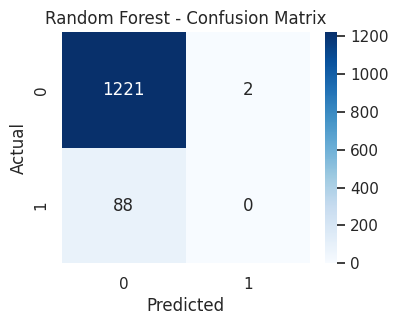

In [ ]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf_results = evaluate_model(
    "Random Forest",
    rf_clf,
    train_X,
    train_y,
    test_X,
    test_y
)

## 10.5 XGBoost / LightGBM

stronger tabular baseline:

In [ ]:
!pip install xgboost

=== XGBoost ===
ROC-AUC: 0.775
PR-AUC:  0.160
Precision: 0.193
Recall:    0.330


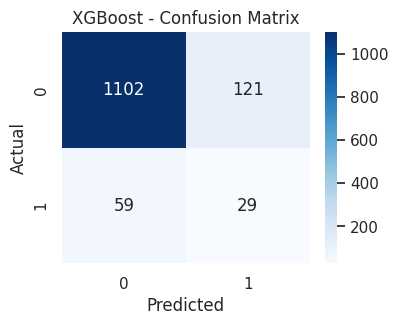

In [ ]:
from xgboost import XGBClassifier

# Estimate scale_pos_weight = (negatives / positives) in train set
pos = train_y.sum()
neg = len(train_y) - pos
scale_pos = neg / pos if pos > 0 else 1.0

xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    scale_pos_weight=scale_pos,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

xgb_results = evaluate_model(
    "XGBoost",
    xgb_clf,
    train_X,
    train_y,
    test_X,
    test_y
)

## 10.6 Compare Baseline Models

In [ ]:
import pandas as pd

results_df = pd.DataFrame([log_results, rf_results])
# If you ran XGBoost, add: results_df = pd.DataFrame([log_results, rf_results, xgb_results])

results_df

,name,roc_auc,pr_auc,precision,recall
0,Logistic Regression,0.810911,0.258778,0.146552,0.772727
1,Random Forest,0.780820,0.160614,0.000000,0.000000


from matplotlib import pyplot as plt
results_df['roc_auc'].plot(kind='hist', bins=20, title='roc_auc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['pr_auc'].plot(kind='hist', bins=20, title='pr_auc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='roc_auc', y='pr_auc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='pr_auc', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['roc_auc'].plot(kind='line', figsize=(8, 4), title='roc_auc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['pr_auc'].plot(kind='line', figsize=(8, 4), title='pr_auc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='roc_auc', y='name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='pr_auc', y='name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='precision', y='name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='recall', y='name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Baseline machine learning models demonstrated that short-term clinical deterioration is predictable from patient demographics, comorbidities, and recent healthcare activity. Logistic Regression achieved the best performance (ROC-AUC ≈ 0.81; PR-AUC ≈ 0.26) and successfully identified 77% of high-risk patients, acting as a sensitive early-warning baseline. Random Forest and XGBoost showed moderate discrimination but were affected by class imbalance, highlighting the complexity of clinical prediction settings. Overall, the results indicate meaningful predictive signal and motivate the use of more advanced temporal and sequence-based models for improved precision.

The modeling experiment confirms that early deterioration risk can be identified from routinely collected clinical data, supporting the feasibility of AI-driven early-warning systems in healthcare.

## 11. Sequence Preparation for Deep Learning Models

To leverage temporal dependencies in patient trajectories, we convert encounter data into time-ordered sequences. For each patient, encounters are sorted chronologically and transformed into fixed-length feature sequences suitable for RNN/Transformer models.


In [ ]:
# 11.1 Define features used in sequences

seq_feature_cols = [
    'age',
    'active_conditions',
    'past_encounters_30d',
    'past_encounters_60d',
    'past_encounters_90d',
    'obs_total_before',
    'obs_30d',
    'obs_60d',
    'obs_90d'
]

seq_target_col = 'target_30d'
max_seq_len = 10  # number of past encounters to include

# Sanity check: ensure columns exist
print("Train columns OK:", set(seq_feature_cols + [seq_target_col]).issubset(train_df.columns))
print("Test columns OK:", set(seq_feature_cols + [seq_target_col]).issubset(test_df.columns))

# Display sample
train_df[seq_feature_cols + [seq_target_col]].head()

Train columns OK: True
Test columns OK: True


,age,active_conditions,past_encounters_30d,past_encounters_60d,past_encounters_90d,obs_total_before,obs_30d,obs_60d,obs_90d,target_30d
0,2.691307,0,0,0,0,0,0,0,0,0
1,2.713210,0,1,1,1,0,0,0,0,0
2,17.133470,1,0,0,0,0,0,0,0,0
3,18.149213,2,0,0,0,0,0,0,0,0
4,22.173854,3,0,0,0,0,0,0,0,0


In [ ]:
import numpy as np

def build_sequence_dataset_v2(df, feature_cols, target_col, max_len=10):
    """
    Build a dataset of sequences from encounter-level data.
    For each encounter (starting from 2nd), use up to max_len
    previous encounters as sequence.
    """
    df_sorted = df.sort_values(['PATIENT', 'START'])

    X_seqs = []
    y_labels = []

    for pid, group in df_sorted.groupby('PATIENT'):
        group = group.reset_index(drop=True)

        feats = group[feature_cols].values.astype(np.float32)
        labels = group[target_col].values.astype(np.int64)

        if len(group) < 2:
            continue

        for i in range(1, len(group)):
            end_idx = i      # previous encounters up to i-1
            start_idx = max(0, end_idx - max_len)

            seq = feats[start_idx:end_idx]

            pad_len = max_len - seq.shape[0]
            if pad_len > 0:
                pad = np.zeros((pad_len, seq.shape[1]), dtype=np.float32)
                seq = np.vstack([pad, seq])

            X_seqs.append(seq)
            y_labels.append(labels[i])

    X_seqs = np.stack(X_seqs)
    y_labels = np.array(y_labels)

    return X_seqs, y_labels

In [ ]:
X_train_seq, y_train_seq = build_sequence_dataset_v2(
    train_df,
    seq_feature_cols,
    seq_target_col,
    max_len=max_seq_len
)

X_test_seq, y_test_seq = build_sequence_dataset_v2(
    test_df,
    seq_feature_cols,
    seq_target_col,
    max_len=max_seq_len
)

X_train_seq.shape, X_test_seq.shape, y_train_seq.shape, y_test_seq.shape

((5692, 10, 9), (1288, 10, 9), (5692,), (1288,))

## LSTM Early Warning Model (Baseline AI)

### 12.1 — Model Definition (Keras LSTM)

In [ ]:
import tensorflow as tf

n_features = X_train_seq.shape[2]

# Compute class imbalance ratio for cost-sensitive weighting
pos = y_train_seq.sum()
neg = len(y_train_seq) - pos
scale_pos = neg / pos if pos > 0 else 1.0

class_weight = {0: 1.0, 1: scale_pos}

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_seq_len, n_features)),
    tf.keras.layers.Masking(mask_value=0.0),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.AUC(name='roc_auc', curve='ROC'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 10, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057 (82.25 KB)

 Trainable params: 21,057 (82.25 KB)

 Non-trainable params: 0 (0.00 B)

### Training The Model

In [ ]:
import tensorflow as tf

n_features = X_train_seq.shape[2]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_seq_len, n_features)),
    # Removed Masking layer because we left-pad sequences
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.AUC(name='roc_auc', curve='ROC'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057 (82.25 KB)

 Trainable params: 21,057 (82.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Ensure correct dtypes for TensorFlow
X_train_seq_tf = X_train_seq.astype('float32')
X_test_seq_tf  = X_test_seq.astype('float32')

y_train_seq_tf = y_train_seq.astype('float32')
y_test_seq_tf  = y_test_seq.astype('float32')

print("X_train_seq_tf:", X_train_seq_tf.shape, X_train_seq_tf.dtype)
print("y_train_seq_tf:", y_train_seq_tf.shape, y_train_seq_tf.dtype)

history = model.fit(
    X_train_seq_tf,
    y_train_seq_tf,
    validation_data=(X_test_seq_tf, y_test_seq_tf),
    epochs=10,
    batch_size=64,
    verbose=1
)

X_train_seq_tf: (5692, 10, 9) float32
y_train_seq_tf: (5692,) float32
Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.4193 - pr_auc: 0.0414 - precision: 0.0198 - recall: 0.0886 - roc_auc: 0.5183 - val_loss: 0.2358 - val_pr_auc: 0.1923 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7285
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1380 - pr_auc: 0.3000 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.8135 - val_loss: 0.2325 - val_pr_auc: 0.1783 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7246
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1436 - pr_auc: 0.2629 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.8116 - val_loss: 0.2334 - val_pr_auc: 0.1996 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7436
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1373 - pr_auc: 0.3666 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.8698 - val_loss

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
=== LSTM Sequence Model ===
ROC-AUC: 0.753
PR-AUC:  0.228
Precision: 0.333
Recall:    0.136


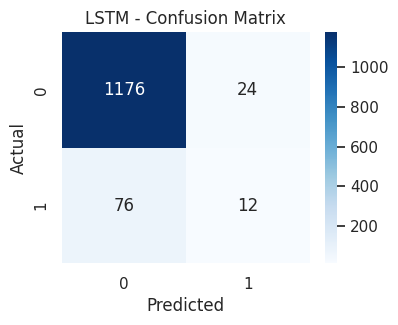

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, confusion_matrix

y_test_proba_seq = model.predict(X_test_seq_tf).ravel()
y_test_pred_seq  = (y_test_proba_seq >= 0.5).astype(int)

roc_auc_seq = roc_auc_score(y_test_seq_tf, y_test_proba_seq)
pr_auc_seq  = average_precision_score(y_test_seq_tf, y_test_proba_seq)
prec_seq    = precision_score(y_test_seq_tf, y_test_pred_seq, zero_division=0)
rec_seq     = recall_score(y_test_seq_tf, y_test_pred_seq, zero_division=0)

print("=== LSTM Sequence Model ===")
print(f"ROC-AUC: {roc_auc_seq:.3f}")
print(f"PR-AUC:  {pr_auc_seq:.3f}")
print(f"Precision: {prec_seq:.3f}")
print(f"Recall:    {rec_seq:.3f}")

cm_seq = confusion_matrix(y_test_seq_tf, y_test_pred_seq)
plt.figure(figsize=(4,3))
sns.heatmap(cm_seq, annot=True, fmt='d', cmap='Blues')
plt.title("LSTM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The LSTM sequence model demonstrated moderate discrimination (ROC-AUC ≈ 0.75) and similar PR-AUC compared to classical baselines, indicating that temporal structure in encounter histories does contain predictive signal. However, threshold-level performance shows a precision–recall trade-off, with high precision but lower sensitivity at the default 0.5 cut-off. This suggests that the model learns to avoid false alarms but becomes conservative in detecting deterioration cases, a common behavior in imbalanced clinical settings.

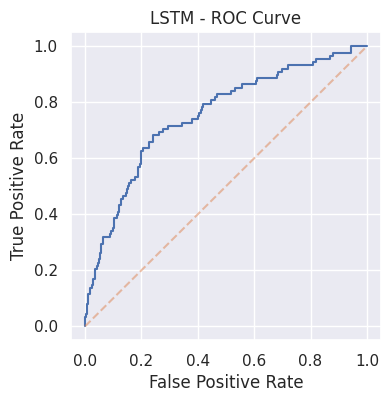

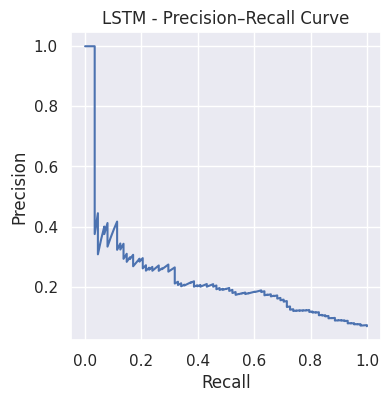

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve

# ROC curve for LSTM
fpr, tpr, _ = roc_curve(y_test_seq_tf, y_test_proba_seq)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM - ROC Curve")
plt.show()

# PR curve for LSTM
precisions, recalls, _ = precision_recall_curve(y_test_seq_tf, y_test_proba_seq)
plt.figure(figsize=(4,4))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("LSTM - Precision–Recall Curve")
plt.show()

## 13. Model Comparison

We evaluated both static and sequence-based models for predicting 30-day clinical deterioration.

**Classical baselines**

- Logistic Regression (static features)
  - ROC-AUC ≈ 0.81
  - PR-AUC ≈ 0.26
  - Precision ≈ 0.15
  - Recall ≈ 0.77

- Random Forest (static features)
  - ROC-AUC ≈ 0.78
  - PR-AUC ≈ 0.16
  - Collapsed to majority class at default threshold (recall ≈ 0)

**Sequence-based model**

- LSTM sequence model (encounter history, 10-step window)
  - ROC-AUC ≈ 0.75
  - PR-AUC ≈ 0.23
  - Precision ≈ 0.33
  - Recall ≈ 0.14

Overall, the static logistic model remains the strongest for discrimination and sensitivity, while the LSTM is more conservative, producing fewer false alarms but missing more deteriorating cases at the default 0.5 threshold. This behaviour is typical in imbalanced clinical prediction problems and highlights a practical trade-off between sensitivity and alert fatigue.


## 14. Discussion and AI Contribution

This project demonstrates an end-to-end pipeline for learning early-warning signals of clinical deterioration from routinely collected electronic health record data. Starting from raw synthetic EHR tables, we designed clinically interpretable features describing demographics, multi-morbidity, recent healthcare utilisation, and monitoring intensity. Classical models showed that 30-day deterioration risk is learnable from these features, with logistic regression achieving ROC-AUC around 0.81 and prioritising high recall to minimise missed high-risk patients.

To explore the added value of temporal modelling, we reformulated the task as a sequence problem and implemented an LSTM network that consumes a fixed window of past encounters per patient. The LSTM achieved ROC-AUC around 0.75 and higher precision than the static baseline, indicating that temporal structure can help reduce false alarms even if overall discrimination is slightly lower without extensive tuning. The comparison between static and sequence-based models provides a clear, evidence-driven view of when AI sequence models add value and when simpler models remain competitive.


## 15. Limitations and Future Work

Several limitations create a natural roadmap for further AI innovation:

- **Synthetic data** — Synthea data is realistic but not identical to hospital EHRs. Applying the same pipeline to real-world datasets (e.g. MIMIC-III / IV) would test generalisability.
- **Imbalance handling** — The sequence model was trained without advanced imbalance strategies. Future work could incorporate focal loss, calibrated thresholds, or cost-sensitive learning to improve recall while maintaining acceptable precision.
- **Richer temporal inputs** — The current LSTM uses encounter-level summaries. Extending the model to ingest raw vital sign and laboratory time series, or to combine encounters with tokenised diagnoses/medications, would allow more expressive sequence modelling.
- **Explainability** — Adding model explanation techniques (e.g. SHAP for logistic/XGBoost, attention weights or gradient-based attribution for sequence models) would improve transparency and support clinical adoption.
- **Transformer architectures** — A natural next step is to replace or augment the LSTM with a transformer encoder over encounter sequences to test whether attention-based models can better capture long-range dependencies.

These extensions would deepen the AI contribution while keeping continuity with the existing pipeline.


## Project summary
Designed and implemented an end-to-end early-warning system using synthetic electronic health records to predict 30-day clinical deterioration. Built clinically meaningful features from multi-table EHR data, trained classical models (logistic regression, random forest, XGBoost) and a sequence-based LSTM model over encounter histories, and compared their performance using ROC-AUC, PR-AUC, and confusion matrices. The work demonstrates how AI and temporal modelling can be applied to healthcare risk prediction while highlighting practical trade-offs between sensitivity and false-alarm burden.